In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# import tensorflow as tf
# from tensorflow.keras.layers import Activation, Dropout, Dense, LeakyReLU
# from tensorflow.keras import Sequential

import torch
from torch import nn
import torch.optim as optim

from tqdm import tqdm

In [2]:
file='stress_summary.csv'
dfstress=pd.read_csv(file)
dfstress.head(5)

,jobid,xcoord,ycoord,zcoord,Mises
0,model0000,1.765090,3.513055,0.0,981.961761
1,model0000,1.608500,4.252800,0.0,13.871708
2,model0000,3.140261,2.451003,0.0,1906.931213
3,model0000,2.102374,3.004073,0.0,2132.610352
4,model0000,2.719147,2.573021,0.0,2319.990723


In [3]:
df_models=pd.read_csv('model_definitions.csv')

#landing spots for stresses: stress_i
for i in range(1,51):
    df_models['Stress_'+str(i)]=''

df_models.set_index('jobid', inplace=True)
df_models.head()

,L1,L2,L3,L4,H1,R1,R2,Stress_1,Stress_2,Stress_3,...,Stress_41,Stress_42,Stress_43,Stress_44,Stress_45,Stress_46,Stress_47,Stress_48,Stress_49,Stress_50
jobid,,,,,,,,,,,,,,,,,,,,,
model0000,4.2528,5.1383,2.4272,1.6085,2.6192,1.8256,0.3057,,,,...,,,,,,,,,,
model0001,4.0728,7.0055,2.7165,2.9818,2.7783,1.3563,0.2710,,,,...,,,,,,,,,,
model0002,4.0588,5.9513,1.9989,1.9095,1.7764,2.0600,0.5268,,,,...,,,,,,,,,,
model0003,5.7358,6.3318,3.1162,3.2121,3.1042,2.6196,0.5587,,,,...,,,,,,,,,,
model0004,4.1967,6.3250,1.8852,3.0049,2.1143,2.3115,0.3814,,,,...,,,,,,,,,,


In [4]:
jobs=dfstress['jobid'].unique().tolist()
len(jobs)

1983

In [5]:
#Normalize stresses
#Iterating over jobs that ran
for job in tqdm(jobs):

    xcoords=dfstress[dfstress['jobid']==job].xcoord.to_numpy()
    ycoords=dfstress[dfstress['jobid']==job].ycoord.to_numpy()
    mises=dfstress[dfstress['jobid']==job].Mises.to_numpy()

    #90° fillet, find center and transfer to local coordinates
    cy = ycoords.max()
    ylocal=ycoords-cy

    #Normalized angle, [0, 1] starting at 9 o'clock, going to 6 o'clock ccw
    angle = np.arcsin(ylocal/ylocal.min()) / np.arcsin(ylocal/ylocal.min()).max()

    #Fit interpolator
    finterp=interpolate.interp1d(angle, mises)

    #Interpolation to regular spacing
    xnew = np.linspace(0,1,50)
    misesnorm = finterp(xnew)

    #store in dataframe
    for i in range(1,51):
        df_models.at[job,'Stress_'+str(i)]=misesnorm[i-1]

100%|██████████████████████████████████████| 1983/1983 [00:23<00:00, 86.14it/s]


In [6]:
#Prune rows for jobs that failed
failed = df_models[df_models['Stress_1']==''].index.tolist()

df_models=df_models.drop(failed)
df_models.shape

(1983, 57)

In [7]:
df_models

,L1,L2,L3,L4,H1,R1,R2,Stress_1,Stress_2,Stress_3,...,Stress_41,Stress_42,Stress_43,Stress_44,Stress_45,Stress_46,Stress_47,Stress_48,Stress_49,Stress_50
jobid,,,,,,,,,,,,,,,,,,,,,
model0000,4.2528,5.1383,2.4272,1.6085,2.6192,1.8256,0.3057,13.871708,12.334601,11.833697,...,2142.555444,2076.362907,2010.652918,1957.657394,1902.851206,1807.571588,1712.29197,1617.809542,1524.058885,1430.308228
model0002,4.0588,5.9513,1.9989,1.9095,1.7764,2.0600,0.5268,48.381531,29.893296,11.405061,...,3487.061436,3368.830228,3247.662897,3142.240701,3044.71876,2924.036535,2778.13276,2632.315934,2486.801278,2341.286621
model0003,5.7358,6.3318,3.1162,3.2121,3.1042,2.6196,0.5587,6.809675,7.094964,8.162865,...,945.498563,874.408177,803.720729,733.080011,664.532592,596.581824,548.261999,500.069637,460.380811,420.691986
model0004,4.1967,6.3250,1.8852,3.0049,2.1143,2.3115,0.3814,16.417873,13.903301,13.100347,...,2387.332013,2286.181763,2187.151339,2099.033919,2010.916499,1876.025315,1739.04928,1603.986685,1471.008113,1338.029541
model0005,3.7496,5.3787,1.6092,2.6510,1.1491,2.1404,0.6420,18.319878,15.50482,14.056624,...,2231.359845,2148.095677,2054.055926,1924.959015,1798.857229,1676.891398,1535.872943,1382.411293,1226.595146,1070.199402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
model1996,6.4775,5.3805,4.3494,1.9655,3.9761,2.1281,0.5583,9.118735,8.509167,8.356746,...,912.968679,867.907938,822.847197,772.886246,718.446405,664.006564,610.955348,561.83185,512.708352,463.584854
model1997,4.2310,6.4296,2.3587,2.1447,2.1387,1.8724,0.4823,19.906971,16.902169,14.60204,...,3199.711038,3074.152947,2962.765826,2852.479955,2731.055408,2617.113954,2506.059725,2362.782785,2212.425658,2054.983704
model1998,4.8771,7.4977,2.8507,2.4821,2.5218,2.0263,0.5801,20.419123,18.016566,16.678366,...,2842.873904,2733.588869,2622.756862,2506.627746,2396.245677,2294.127784,2178.080819,2052.614304,1924.950997,1796.799622


In [8]:
#Calculate ligament thickness

def ligament(row):
    dx = row['R1'] #L4+R1-L4
    dy = row['L1'] - row['H1']
    
    return np.sqrt(dx**2 + dy**2)


df_models['ligament'] = df_models[['L1', 'L2', 'L3', 'L4', 'H1', 'R1', 'R2']].apply(ligament, axis=1)
df_models.head()

,L1,L2,L3,L4,H1,R1,R2,Stress_1,Stress_2,Stress_3,...,Stress_42,Stress_43,Stress_44,Stress_45,Stress_46,Stress_47,Stress_48,Stress_49,Stress_50,ligament
jobid,,,,,,,,,,,,,,,,,,,,,
model0000,4.2528,5.1383,2.4272,1.6085,2.6192,1.8256,0.3057,13.871708,12.334601,11.833697,...,2076.362907,2010.652918,1957.657394,1902.851206,1807.571588,1712.29197,1617.809542,1524.058885,1430.308228,2.449789
model0002,4.0588,5.9513,1.9989,1.9095,1.7764,2.0600,0.5268,48.381531,29.893296,11.405061,...,3368.830228,3247.662897,3142.240701,3044.71876,2924.036535,2778.13276,2632.315934,2486.801278,2341.286621,3.074565
model0003,5.7358,6.3318,3.1162,3.2121,3.1042,2.6196,0.5587,6.809675,7.094964,8.162865,...,874.408177,803.720729,733.080011,664.532592,596.581824,548.261999,500.069637,460.380811,420.691986,3.713169
model0004,4.1967,6.3250,1.8852,3.0049,2.1143,2.3115,0.3814,16.417873,13.903301,13.100347,...,2286.181763,2187.151339,2099.033919,2010.916499,1876.025315,1739.04928,1603.986685,1471.008113,1338.029541,3.111177
model0005,3.7496,5.3787,1.6092,2.6510,1.1491,2.1404,0.6420,18.319878,15.50482,14.056624,...,2148.095677,2054.055926,1924.959015,1798.857229,1676.891398,1535.872943,1382.411293,1226.595146,1070.199402,3.368073


In [9]:
#Additional feature(s)
#Length from fillet to free end
df_models['L5']=df_models['L2']-df_models['L4']-df_models['R1']

#L3/L1 ratio
df_models['L3L1']=df_models['L3']/df_models['L1']

#R1/L1 ratio
df_models['R1L1']=df_models['R1']/df_models['L1']

#L3**2
#df_models['L3xL3']=df_models['L3']*df_models['L3']

df_models.head()

,L1,L2,L3,L4,H1,R1,R2,Stress_1,Stress_2,Stress_3,...,Stress_45,Stress_46,Stress_47,Stress_48,Stress_49,Stress_50,ligament,L5,L3L1,R1L1
jobid,,,,,,,,,,,,,,,,,,,,,
model0000,4.2528,5.1383,2.4272,1.6085,2.6192,1.8256,0.3057,13.871708,12.334601,11.833697,...,1902.851206,1807.571588,1712.29197,1617.809542,1524.058885,1430.308228,2.449789,1.7042,0.570730,0.429270
model0002,4.0588,5.9513,1.9989,1.9095,1.7764,2.0600,0.5268,48.381531,29.893296,11.405061,...,3044.71876,2924.036535,2778.13276,2632.315934,2486.801278,2341.286621,3.074565,1.9818,0.492485,0.507539
model0003,5.7358,6.3318,3.1162,3.2121,3.1042,2.6196,0.5587,6.809675,7.094964,8.162865,...,664.532592,596.581824,548.261999,500.069637,460.380811,420.691986,3.713169,0.5001,0.543290,0.456710
model0004,4.1967,6.3250,1.8852,3.0049,2.1143,2.3115,0.3814,16.417873,13.903301,13.100347,...,2010.916499,1876.025315,1739.04928,1603.986685,1471.008113,1338.029541,3.111177,1.0086,0.449210,0.550790
model0005,3.7496,5.3787,1.6092,2.6510,1.1491,2.1404,0.6420,18.319878,15.50482,14.056624,...,1798.857229,1676.891398,1535.872943,1382.411293,1226.595146,1070.199402,3.368073,0.5873,0.429166,0.570834


In [10]:
#Prepare lists of input and output columns
columns = df_models.columns.tolist()

inputcols=[]
outputcols=[]
for col in columns:
    if 'Stress' in col:
        outputcols.append(col)
    else:
        inputcols.append(col)
        

In [11]:
#Extract from dataframe to arrays
inputs = df_models[inputcols].to_numpy().astype(np.float32)
outputs = df_models[outputcols].to_numpy().astype(np.float32)

In [12]:
#Test train split w/ 80% training, 10% validation, 10% test
inputs_train, inputs_remain, outputs_train, outputs_remain = train_test_split(inputs, outputs, test_size=0.2, random_state=19)
inputs_test, inputs_val, outputs_test, outputs_val = train_test_split(inputs_remain, outputs_remain, test_size=0.5, random_state=37)

In [13]:
#Scale to range [0,1] on Train data, transform Val and Test to prevent leakage
#Inputs
in_scaler = MinMaxScaler()
inputs_train = in_scaler.fit_transform(inputs_train)
inputs_test = in_scaler.transform(inputs_test)
inputs_val = in_scaler.transform(inputs_val)

#Outputs
out_scaler = MinMaxScaler()
outputs_train = out_scaler.fit_transform(outputs_train)
outputs_test = out_scaler.transform(outputs_test)
outputs_val = out_scaler.transform(outputs_val)

In [14]:
#Input, output dimensions 
inputs_train.shape[1], outputs_train.shape[1]

(11, 50)

In [15]:
#Convert Inputs, Outputs to Torch tensors
inputs_train = torch.tensor(inputs_train, dtype=torch.float32)
inputs_test = torch.tensor(inputs_test, dtype=torch.float32)
inputs_val = torch.tensor(inputs_val, dtype=torch.float32)

outputs_train = torch.tensor(outputs_train, dtype=torch.float32)
outputs_test = torch.tensor(outputs_test, dtype=torch.float32)
outputs_val = torch.tensor(outputs_val, dtype=torch.float32)

In [16]:
#Create model
#Attempt to use same architecture and training as TensorFlow Notebook

#Number of Neurons in hidden layers (multiplier may be applied)
n_neurons=512

class Surrogate(nn.Module): # all the dependencies from torch will be given to this class [parent class] # nn.Module contains all the building block of neural networks:
    def __init__(self,input_dim, output_dim):
        super(Surrogate,self).__init__()  
        #Fully connected layers
        self.fc1=nn.Linear(input_dim,4*n_neurons)
        self.fc2=nn.Linear(4*n_neurons,8*n_neurons)
        self.fc3=nn.Linear(8*n_neurons,4*n_neurons)
        self.fc4=nn.Linear(4*n_neurons,n_neurons)
        self.fc5=nn.Linear(n_neurons,output_dim)

    def forward(self,x):
        #Construct layers
        x=self.fc1(x)
        x=torch.relu(x)  
        
        x=self.fc2(x)
        x=torch.relu(x)  
        
        x=self.fc3(x)
        x=torch.relu(x) 
        
        x=self.fc4(x)
        x=torch.relu(x) 
        
        x=self.fc5(x)                        
        return x                               


#Create model    
input_dim=inputs_train.shape[1]
output_dim=outputs_train.shape[1]

torch.manual_seed(41)
model=Surrogate(input_dim, output_dim)

In [17]:
#Loss
loss=nn.MSELoss()

#Optimizer
opt=optim.Adam(params=model.parameters(), lr=0.001)

In [18]:
# training the model:
loss_history=[]

#Early stopping
patience=10

num_of_epochs=200
for i in range(num_of_epochs):
    
    # zero gradients
    opt.zero_grad() 
    
    # predict
    y_pred=model(inputs_train)  
    
    # calculate loss and save
    loss_value=loss(y_pred.squeeze(),outputs_train) 
    loss_history.append(loss_value.detach().numpy())

    # back prop
    loss_value.backward()  
    
    # update weights
    opt.step()  

    # print the loss in training part:
    if i % 20 == 0:
        print(f'Epoch: {i}: Loss={loss_value}')
    
    #Calcaulte if Loss has not improved in 'patience' epochs
    minloss=np.array(loss_history).argmin()
    if i - minloss > patience:
        print(f'Early Stopping activated; Loss has not improved in {patience} epochs')
        break

Epoch: 0: Loss=0.07022637128829956
Epoch: 20: Loss=0.004760530311614275
Epoch: 40: Loss=0.0022121663205325603
Epoch: 60: Loss=0.001463031629100442
Epoch: 80: Loss=0.0010008264798671007
Epoch: 100: Loss=0.0008334139711223543
Epoch: 120: Loss=0.0007171090110205114
Epoch: 140: Loss=0.0006933388067409396
Epoch: 160: Loss=0.0006115281721577048
Epoch: 180: Loss=0.0006603412330150604
Early Stopping activated; Loss has not improved in 10 epochs


Text(0, 0.5, 'Loss')

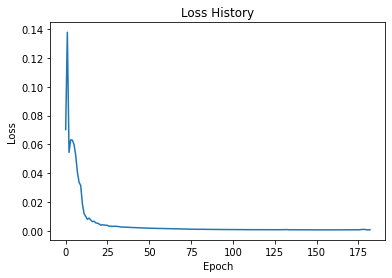

In [19]:
#plot loss history
plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [20]:
# evaluate model:
model.eval()

with torch.no_grad():
    outputs_preds = model(inputs_test)
    test_loss=loss(outputs_preds.squeeze(), outputs_test)
    print(f'Test loss value : {test_loss.item():.4f}')

Test loss value : 0.0010


In [21]:
#Generate Predictions from Test dataset
predictions=model(inputs_test)

In [22]:
#Convert to Numpy for plotting
predictions=predictions.detach().numpy()

In [26]:
#Inverse Transform to FEA magnitudes
outputs_test=out_scaler.inverse_transform(outputs_test)
predictions=out_scaler.inverse_transform(predictions)

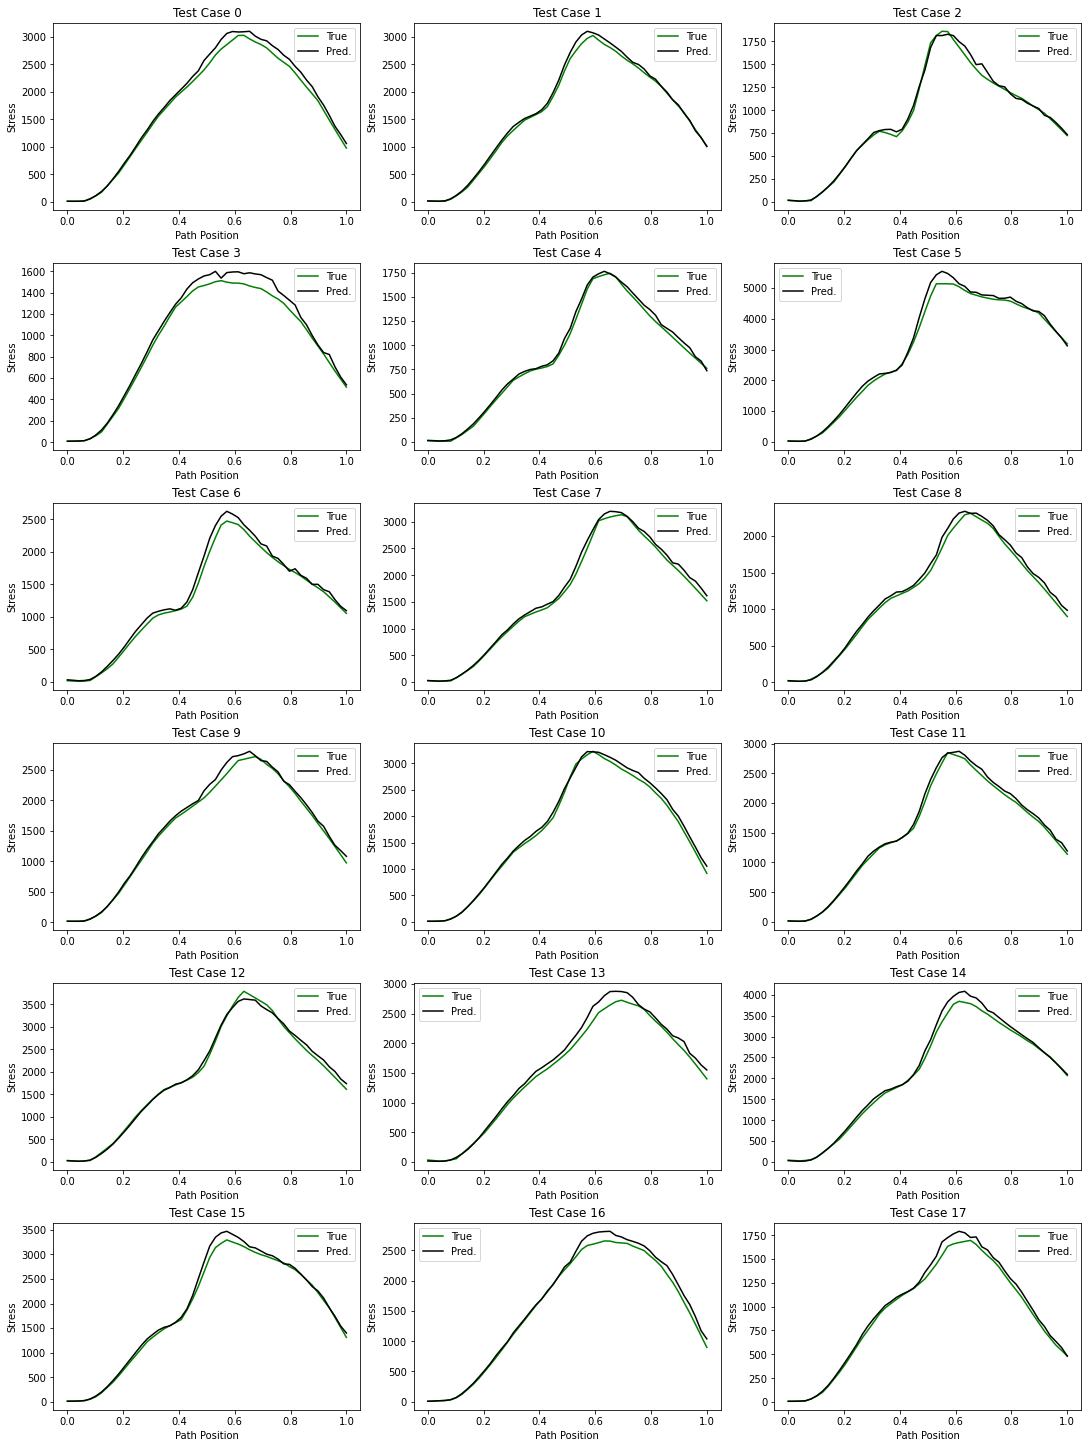

In [27]:
#Plot True and Predicted values along normalized fillet path
#Set up grid of plots
nrow=6
ncol=3

fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(15, 20), layout="constrained")

for i in range(nrow*ncol):

    l1=axs[i//3, i%3].plot(xnew, outputs_test[i], '-g', label='True')
    l2=axs[i//3, i%3].plot(xnew, predictions[i], '-k', label='Pred.')
    axs[i//3, i%3].set_xlabel('Path Position')
    axs[i//3, i%3].set_ylabel('Stress')
    axs[i//3, i%3].set_title('Test Case '+str(i))
    axs[i//3, i%3].legend()

Text(0, 0.5, 'Predicted')

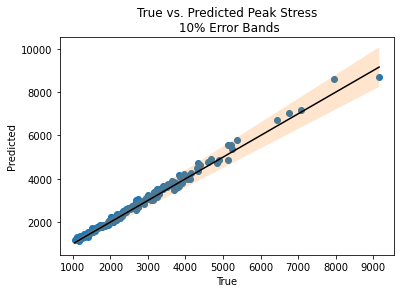

In [28]:
#Error plot
truemaxima=[]
predmaxima=[]
for i in range(predictions.shape[0]):
    truemaxima.append(outputs_test[i,:].max())
    predmaxima.append(predictions[i,:].max())
    
truemaxima=np.array(truemaxima)
predmaxima=np.array(predmaxima)

    
plt.scatter(truemaxima, predmaxima)
plt.plot([truemaxima.min(), truemaxima.max()], [truemaxima.min(), truemaxima.max()], '-k')

#Error band
err = .1
xlist=[truemaxima.min(), truemaxima.max()]
ylist_upper=[(1+err)*truemaxima.min(), (1+err)*truemaxima.max()]
ylist_lower=[(1-err)*truemaxima.min(), (1-err)*truemaxima.max()]
plt.fill_between(xlist, ylist_lower, ylist_upper, alpha=0.2)
# plt.plot(xlist, , '-g')
# plt.plot(xlist, , '-r')

plt.title('True vs. Predicted Peak Stress\n 10% Error Bands')
plt.xlabel('True')
plt.ylabel('Predicted')